## Load data

In [2]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip traffic-signs-data.zip

--2022-02-02 12:05:05--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 18.67.79.229, 18.67.79.63, 18.67.79.147, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|18.67.79.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  39.4MB/s    in 3.0s    

2022-02-02 12:05:08 (39.4 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


(<matplotlib.image.AxesImage at 0x7f494cb12090>,
 41,
 34799,
 [32, 32, 3],
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8))

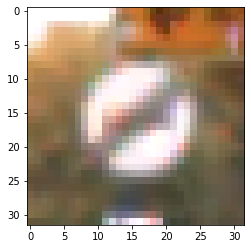

In [6]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.utils import shuffle

data_dir = "/content"
train = pickle.load(open(f"{data_dir}/train.p", "rb"))
test = pickle.load(open(f"{data_dir}/test.p", "rb"))
val = pickle.load(open(f"{data_dir}/valid.p", "rb"))

sample_img = train["features"][120]
sample_lbl = train["labels"][120]

get_feature_labels = lambda x: (x["features"], x["labels"])
train_img, train_lbls = get_feature_labels(train)
test_img, test_lbls = get_feature_labels(test)
val_img, val_lbls = get_feature_labels(val)

# shuffle
train_img, train_lbls = shuffle(train_img, train_lbls)
test_img, test_lbls = shuffle(test_img, test_lbls)
val_img, val_lbls = shuffle(val_img, val_lbls)


train_size, *input_shape = train_img.shape
unique_lbls = np.unique(train_lbls)

# features, coords, labels, sizes
plt.imshow(sample_img), sample_lbl, train_size, input_shape, unique_lbls

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, smart_resize
train_img = smart_resize(train_img, size=(32, 32))
test_img = smart_resize(test_img, size=(32, 32))
val_img = smart_resize(val_img, size=(32, 32))

imgDataGen = ImageDataGenerator(
                                # rotation_range=0.2,
                                # width_shift_range=0.2, 
                                # height_shift_range=0.2,
                                # zoom_range=0.2, 
                                vertical_flip=True,
                                rescale=1/255.,
                                horizontal_flip=True)
aug_train_ds = imgDataGen.flow(train_img, train_lbls)
aug_test_ds = imgDataGen.flow(test_img, test_lbls)
aug_val_ds = imgDataGen.flow(val_img, val_lbls)
aug_train_ds, val_img.shape

(<keras.preprocessing.image.NumpyArrayIterator at 0x7f4944ad4790>,
 (4410, 32, 32, 3))

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_lbls)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_img, test_lbls)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_lbls)).batch(32).prefetch(tf.data.AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.uint8)>

In [32]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Conv2D(32, 3, padding="same", name="conv2d_1", activation="relu", input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2,2), name="maxpool2d_1"),

    layers.Conv2D(64, 3, padding="same", name="conv2d_2", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2), name="maxpool2d_2"),

    layers.Conv2D(128, 3, padding="same", name="conv2d_3", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2), name="maxpool2d_3"),

    layers.Flatten(),
    layers.Dense(128, name="dense_128", activation="relu"),
    
    layers.Dense(len(unique_lbls), name="output", activation="softmax"),
])

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 maxpool2d_3 (MaxPooling2D)  (None, 4, 4, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)             

In [36]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=[
                         tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy"),
                         tf.keras.callbacks.ModelCheckpoint("/content/model_cp/model_1", save_best_only=True)     
                    ])

Epoch 1/30
1088/1088 [==============================] - 98s 88ms/step - loss: 1.2056 - accuracy: 0.7289 - val_loss: 0.5733 - val_accuracy: 0.8662
Epoch 2/30
1088/1088 [==============================] - 92s 84ms/step - loss: 0.1829 - accuracy: 0.9501 - val_loss: 0.5043 - val_accuracy: 0.8757
Epoch 3/30
1088/1088 [==============================] - 93s 85ms/step - loss: 0.1214 - accuracy: 0.9673 - val_loss: 0.4386 - val_accuracy: 0.9181
Epoch 4/30
1088/1088 [==============================] - 92s 85ms/step - loss: 0.1008 - accuracy: 0.9739 - val_loss: 0.3801 - val_accuracy: 0.9202
Epoch 5/30
1088/1088 [==============================] - 90s 83ms/step - loss: 0.0996 - accuracy: 0.9743 - val_loss: 0.5591 - val_accuracy: 0.9045
Epoch 6/30
1088/1088 [==============================] - 87s 80ms/step - loss: 0.0868 - accuracy: 0.9791 - val_loss: 0.8083 - val_accuracy: 0.9213
Epoch 7/30
1088/1088 [==============================] - 89s 82ms/step - loss: 0.0770 - accuracy: 0.9819 - val_loss: 0.4407 -

In [37]:
model.evaluate(test_ds)

395/395 [==============================] - 16s 39ms/step - loss: 0.6692 - accuracy: 0.9227


[0.6692139506340027, 0.922723650932312]

In [38]:
model.load_weights("/content/model_cp/model_1")
model.evaluate(test_ds)

395/395 [==============================] - 15s 36ms/step - loss: 0.4836 - accuracy: 0.9108


[0.48360368609428406, 0.9108471870422363]